# LLM Assignment 1: Representation Surgery (Coding)
**IMPORTANT: MAKE A COPY OF THIS NOTEBOOK AND WORK IN THERE.**

Welcome to the coding part of the Representation Surgery question in Assignment 1.
The goal of this portion is to give you a deeper intuition for how representation surgery works and its strengths/limitations via hands-on implementations.

It consists of 2 parts:
1. Implementing linear concept erasure as described in the assignment, and applying it to a synthetic dataset.
2. Applying concept erasure to erase the concept of "gender" from the BERT representations of a dataset of biographies.

In this assignment, you'll have a series of tasks. For each task you will need to write some code and produce plots and/or accuracy results. You will need to export the notebook as a pdf and attach it to your submission. Please make sure all deliverables for each task (e.g., plots and accuracy results) are clearly visible, as we will be grading you on these outputs.

In [51]:
#!git clone https://github.com/rycolab/llm-representation-surgery.git

In [52]:
# These are all the imports you should need

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from typing import Tuple

np.random.seed(42)

## 0. Constructing a synthetic dataset

First, we'll give you a synthetic dataset encoding a concept, i.e., the target labels.

In [53]:
n, d, k = 2048, 128, 2
X, Z = make_classification(
    n_samples=n,
    n_informative=k,
    n_features=d,
    n_classes=k,
    random_state=1,
)
print(f"Shape of X: {X.shape}, Shape of Z: {Z.shape}")

Shape of X: (2048, 128), Shape of Z: (2048,)


What does this dataset look like? Visualizing 128-dimensional data is hard, so we'll reduce the dimensionality to 2 using CCA and plot the result.

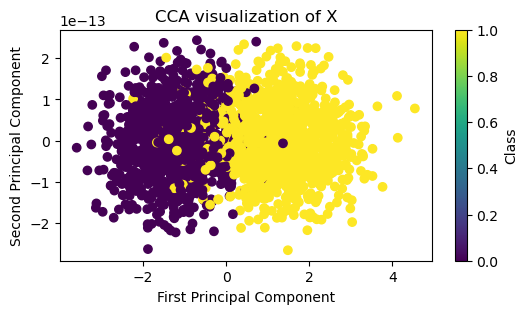

In [54]:
def plot_cca(X, Z):
    """
    Use Canonical Component Analysis to visualize the dataset X and label Z.
    """
    Z_one_hot = np.zeros((len(Z), len(set(Z))))
    Z_one_hot[np.arange(len(Z)), Z] = 1
    cca = CCA(n_components=2)
    X_cca = cca.fit_transform(X, y=Z_one_hot)[0]
    plt.figure(figsize=(6, 3))
    plt.scatter(X_cca[:, 0], X_cca[:, 1], c=Z, cmap='viridis')
    plt.colorbar(label='Class')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('CCA visualization of X')
    plt.show()

plot_cca(X, Z)

As you can see, in these two components, the two concepts are fairly separable.

### Task 0.1: Implement a logistic regression classifier predict the concept $Z$ from $X$.
FOR THE SUBMISSION: Print the accuracy your classifier scores on the data.

In [55]:
def logreg(X: np.ndarray, Z: np.ndarray) -> float:
    """
    Train a logistic regression classifier to predict concept Z from X.

    Args:
        X - the data
        Z - the concept/label

    Return:
        Accuracy in predicting Z from X.
    """
    
    clf = LogisticRegression()
    clf.fit(X, Z)

    Z_pred = clf.predict(X)

    accuracy = np.mean(Z_pred == Z)
    return accuracy

print(f"Accuracy before erasure: {logreg(X, Z):.3f}")

Accuracy before erasure: 0.941


## 1. Implementing linear concept erasure

### Task 1.1: Validate that the resulting whitening and unwhitening matrices satisfy their definition and goals.
That is, verify (a) $WW^{\top} =I$ and (b) $cov(XW) = I$.

FOR THE SUBMISSION: Include your plots showing the whitening matrices.

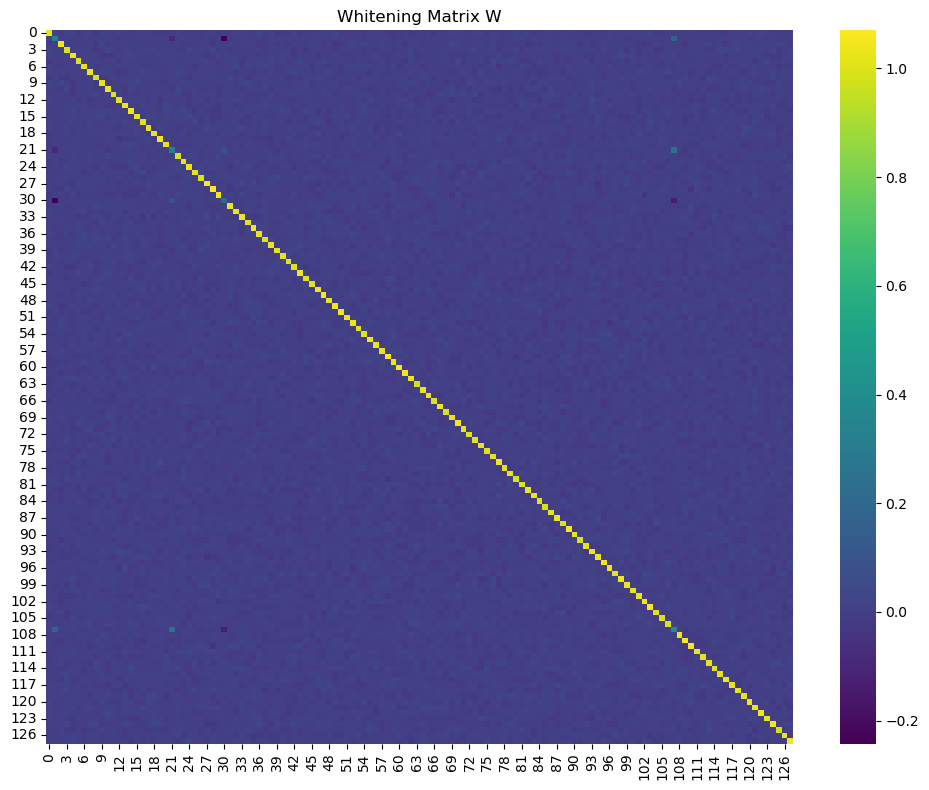

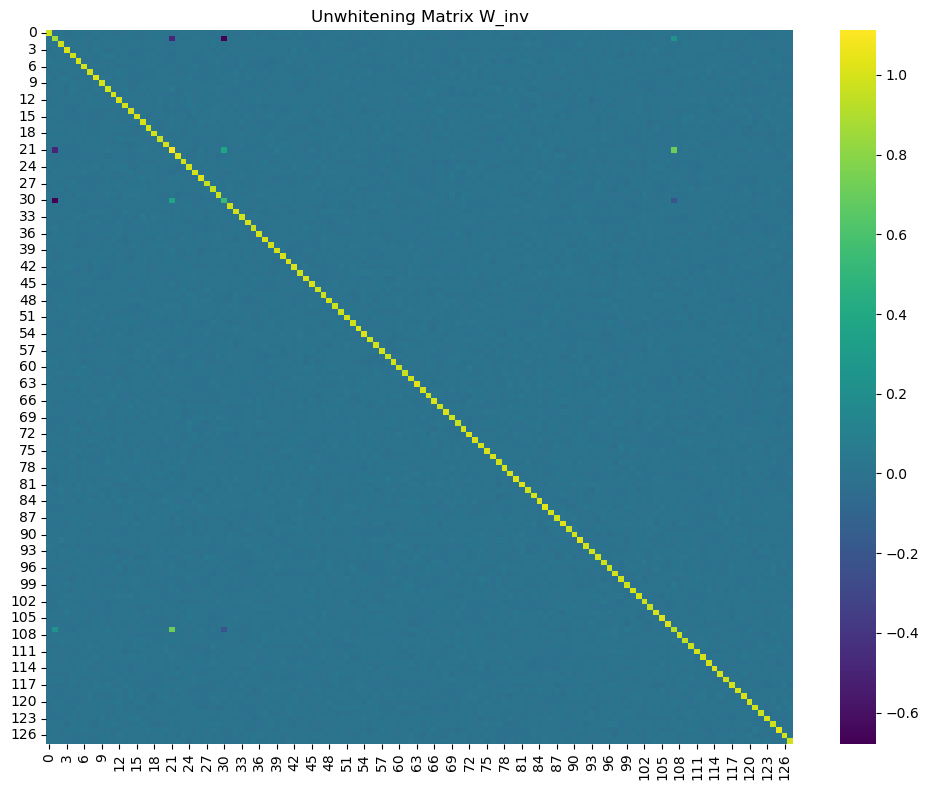

In [56]:
def compute_W(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the whitening and unwhitening matrix for the data using the ZCA whitening method
    (see Appendix A of https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf for more details).
    We give this to you as a numerically stable implementation.
    """
    sigma = np.cov(X.T)

    L, V = np.linalg.eigh(sigma)

    # Assuming PSD; account for numerical error
    L = L.clip(0.0)

    # Threshold used by torch.linalg.pinv
    mask = L > (L[-1] * sigma.shape[-1] * np.finfo(float).eps)

    with np.errstate(divide='ignore'):
      W = V * np.where(mask, 1/np.sqrt(L), 0.0) @ V.T
      W_inv = V * np.where(mask, np.sqrt(L), 0.0) @ V.T

    return W, W_inv

def heatmap(arr, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(arr, cmap='viridis')
    plt.title(title)
    plt.tight_layout()
    plt.show()

W, W_inv = compute_W(X)
heatmap(W, "Whitening Matrix W")
heatmap(W_inv, "Unwhitening Matrix W_inv")

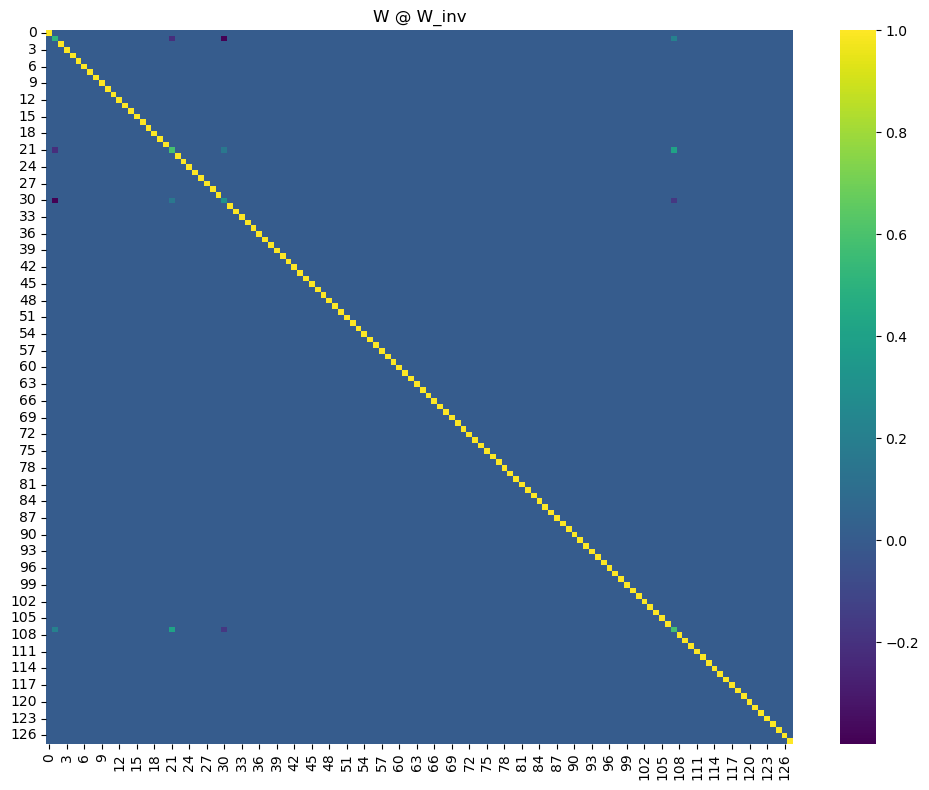

In [57]:
def verify_W_W_inv(W, W_inv):
    """
    Plot a heatmap of W @ W_inv to verify it satisfies the definition of whitening.
    """
    I_approx = W @ W_inv
    heatmap(I_approx, "W @ W_inv")

verify_W_W_inv(W, W_inv)

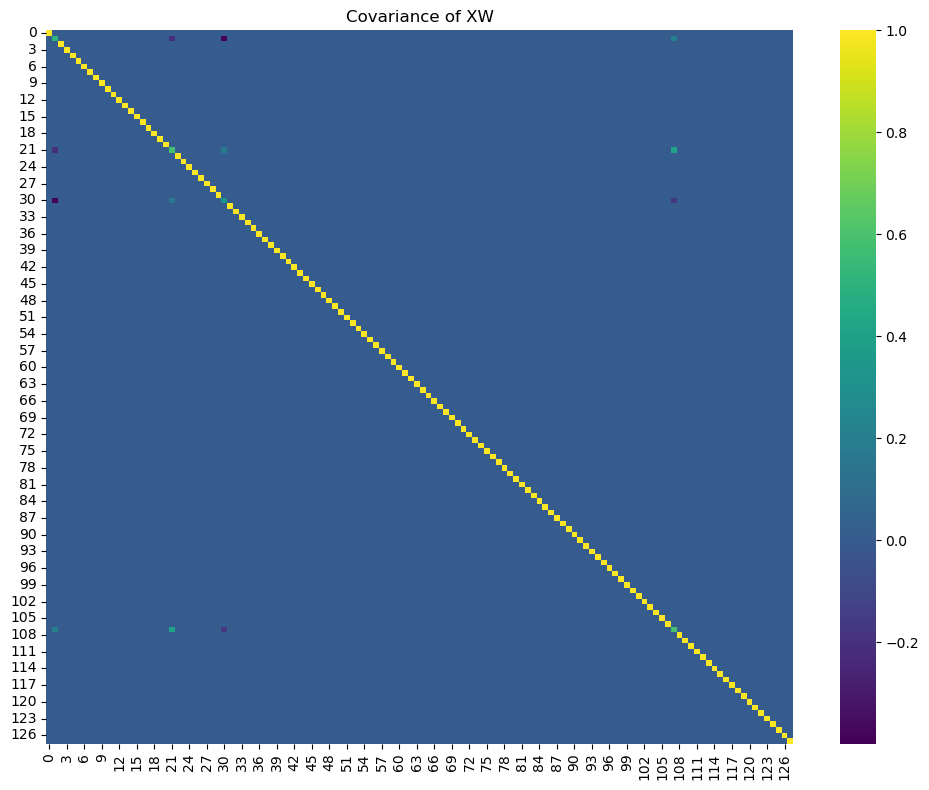

In [58]:
def verify_cov_XW(X, W):
    """
    Plot a heatmap of the covariance of XW to verify it satisfies the definition of whitening.
    """
    X_whitened = X @ W
    cov_whitened = np.cov(X_whitened.T)
    heatmap(cov_whitened, "Covariance of XW")

verify_cov_XW(X, W)

### Task 1.2: Implement linear concept erasure
Use the equations derived from the written part of the assignment.

FOR THE WRITEUP: Include your plot and accuracy of the embeddings before erasure and after erasure.

In [71]:
def erase(X: np.ndarray, Z: np.ndarray) -> np.ndarray:
    """
    Implement linear concept erasure.

    Args:
        X - the data, shape (n, d)
        Z - the concept/label, shape (n,)

    Return:
        The data with the concept erased. Shape (n, d).
    """

    # Center X
    X_centered = X - X.mean(axis=0)

    # One-hot encode Z and center it
    Z_onehot = np.eye(np.max(Z) + 1)[Z]
    Z_centered = Z_onehot - Z_onehot.mean(axis=0)

    # Empirical covaraince of X and Z
    cov_XZ = (X_centered.T @ Z_centered) / len(X)

    W, W_inv = compute_W(X)

    # orthogonal projection (in the whitened space) onto the subspace encoding concept information
    proj = W @ cov_XZ @ np.linalg.pinv(W @ cov_XZ)


    X_erased = X.T - W_inv @ proj @ W @ X_centered.T
    X_erased = X_erased.T

    return X_erased

erased_X = erase(X, Z)

Now, let's validate that the concept has been erased.

c:\Users\Alex\anaconda3\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\Alex\anaconda3\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")


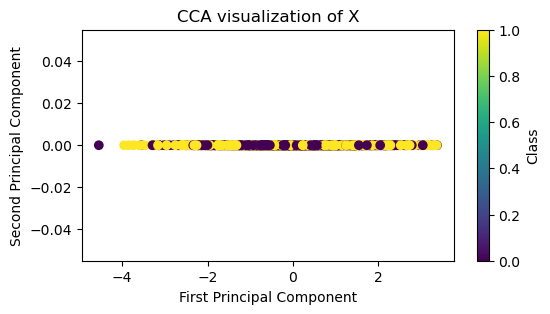

Accuracy after erasure: 0.501953125


In [72]:
plot_cca(erased_X, Z)
print(f"Accuracy after erasure: {logreg(erased_X, Z)}")

## 2. Erasing gender bias
In this portion, we'll apply the same method to a real dataset of word embeddings of biography data. Your goal is to (a) construct sentence embeddings and (b) erase the gender concept from these embeddings. Use the **`hard_text_untokenized`** column for your embeddings.

In [61]:
df = pd.read_csv("data/biographies.csv")
df.head()


,g,p,text,start,hard_text,hard_text_untokenized,text_without_gender
0,f,psychologist,Brandi Smith is a registered psychologist in t...,139,Ms. Smith is experienced in providing psychoth...,Ms. Smith is experienced in providing psychoth...,_. _ is experienced in providing psychotherapy...
1,m,software_engineer,Duarte Nunes is a Software Engineer working on...,56,He has a background in concurrent programming ...,"He has a background in concurrent programming,...","_ has a background in concurrent programming, ..."
2,f,software_engineer,Lauren Ellsworth is a Senior Software Engineer...,139,"In her years of development , Lauren has contr...","In her years of development, Lauren has contri...","In _ years of development, _ has contributed t..."
3,f,professor,Gillian McCann is an Associate Professor in th...,124,She holds a doctorate in Religious Studies in ...,She holds a doctorate in Religious Studies in ...,_ holds a doctorate in Religious Studies in th...
4,m,professor,BIOGRAPHY: Jason Del Gandio (PhD) is an Assist...,113,His area of expertise is the theory and practi...,His area of expertise is the theory and practi...,_ area of expertise is the theory and practice...


### Task 2.1: Compute embeddings and use the `erase` function defined above to erase the gender concept from the embeddings.

FOR THE FOR THE SUBMISSION: Include:
(a) CCA plot of the embeddings before erasure,
(b) CCA plot of the embeddings after erasure,
(c) logistic regression accuracy before erasure, and
(d) logistic regression accuracy after erasure.

In [62]:
from sentence_transformers import SentenceTransformer

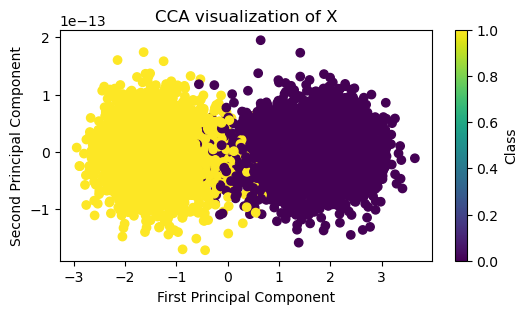

Accuracy before erasure: 0.985


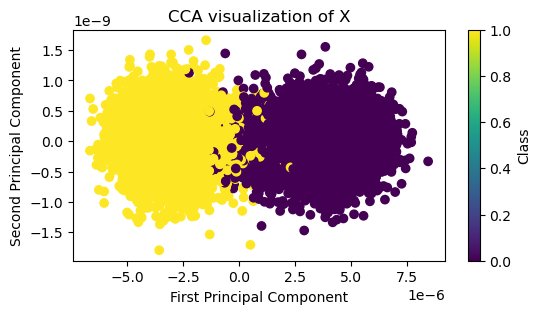

Accuracy after erasure: 0.547


In [63]:
def extract_gender_labels(df: pd.DataFrame) -> np.ndarray:
    """
    Extract the gender labels from the dataframe.
    """
    return (df["g"] == "m").astype(int).to_numpy()

def compute_embeddings(df: pd.DataFrame) -> np.ndarray:
    """
    Compute the embeddings using a pretrained model for the "hard_text_untokenized" column of the given dataframe.
    Feel free to experiment with different models; a good starting point is the classic BERT model, "google-bert/bert-base-uncased".
    Also feel free to use any libraries which would be helpful, such as `transformers` or `sentence_transformers`.
    """
    model = SentenceTransformer("all-MiniLM-L6-v2")
    
    texts = df["hard_text_untokenized"].tolist()
    
    embeddings = model.encode(texts)

    return np.array(embeddings)

def erase_gender(embeddings: np.ndarray, gender_labels: np.ndarray) -> np.ndarray:
    """
    This function should do 3 things:
        1. Erase the gender concept from the embeddings and return these new embeddings.
        2. Visualize the embeddings before erasure and print the accuracy before erasure.
        3. Visualize the embeddings after erasure and print the accuracy after erasure.

    Args:
        embeddings: The embeddings to erase the gender concept from.
        gender_labels: The gender labels for the embeddings.

    Returns:
        The embeddings with the gender concept erased.
    """
    erased_embeddings = erase(embeddings,gender_labels)

    plot_cca(embeddings, gender_labels)
    print(f"Accuracy before erasure: {logreg(embeddings, gender_labels):.3f}")
    plot_cca(erased_embeddings, gender_labels)
    print(f"Accuracy after erasure: {logreg(erased_embeddings, gender_labels):.3f}")

    return erased_embeddings

gender_labels = extract_gender_labels(df)
embeddings = compute_embeddings(df)
embeddings_erased = erase_gender(embeddings, gender_labels)

### Task 2.2: Verifying minimally-destructive edits.
One key aspect of concept erasure is we want the edits to be *minimal*, i.e., they should not destroy other aspects of the representations. To test the degree to which the representation is preserved, use the profession as a proxy. Show that the profession information is preserved within the embeddings by computing the accuracy (a) before erasure and (b) after erasure.

FOR THE SUBMISSION: Report the accuracy before and after erasure.

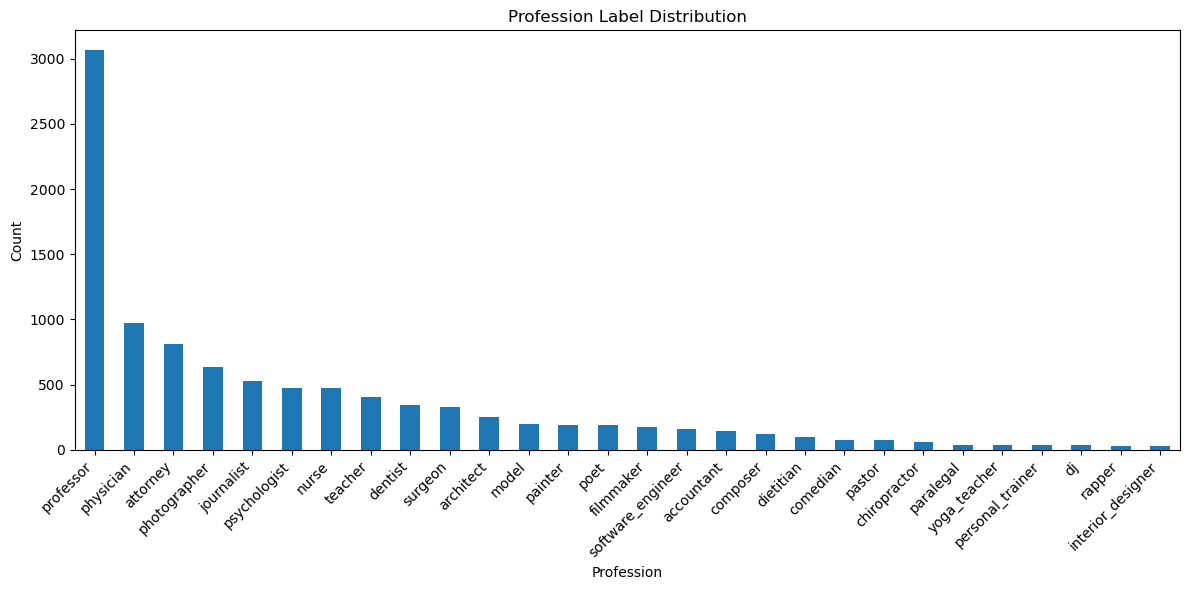

array([3063,  974,  810,  633,  531,  472,  471,  406,  342,  326,  256,
        201,  194,  188,  178,  159,  145,  120,  102,   78,   75,   59,
         41,   40,   37,   36,   34,   29], dtype=int64)

In [64]:
def visualize_profession(df: pd.DataFrame) -> np.ndarray:
    """
    Visualize the label distribution of professions, sorted from highest to lowest.
    """
    profession_counts = df["p"].value_counts()

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    profession_counts.plot(kind="bar")
    plt.title("Profession Label Distribution")
    plt.xlabel("Profession")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return profession_counts.values

visualize_profession(df)

In [65]:
def verify_profession_intact(embeddings: np.ndarray, embeddings_erased: np.ndarray, df: pd.DataFrame) -> np.ndarray:
    """
    Verify the profession information is preserved within the embeddings.
    """

    labels = df["p"]

    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)

    # Accuracy before erasure
    acc_before = logreg(embeddings, y)
    print(f"Accuracy before erasure: {acc_before:.4f}")

    # accuracy after erasure
    acc_after = logreg(embeddings_erased, y)
    print(f"Accuracy after erasure: {acc_after:.4f}")

    return np.array([acc_before, acc_after])
    

verify_profession_intact(embeddings, embeddings_erased, df)

Accuracy before erasure: 0.7848
Accuracy after erasure: 0.7811


array([0.7848, 0.7811])

### Task 2.3: Show that using a nonlinear classifier, you can recover the concept from the erased embeddings.

While we've successfully removed gender from being *linearly encoded* in the embeddings, they can still be extracted using other models. Your goal is to extract the concept using some other model.

FOR THE SUBMISSION: Report the accuracy before and after erasure.

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
def nonlinear_classifier(embeddings: np.ndarray, gender_labels: np.ndarray) -> float:
    """
    Train a nonlinear classifier on the embeddings to predict the gender labels and return the accuracy.
    """
     # Using Random Forest Classifier (non linear classifier)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(embeddings, gender_labels)

    predictions = clf.predict(embeddings)
    accuracy = np.mean(gender_labels == predictions)
    return accuracy

print(f"accuracy before erasure: {nonlinear_classifier(embeddings, gender_labels):.4f}")
print(f"accuracy after erasure: {nonlinear_classifier(embeddings_erased, gender_labels):.4f}")


accuracy before erasure: 1.0000
accuracy after erasure: 1.0000
